### This notebook is used for svm classifier.
To do list:
- [x] svm
- [x] RandomForestClassifier
- [ ] CNN?

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#plt.style.use('seaborn')
import seaborn as sns

import datetime

import os
import glob

import numpy as np
import pandas as pd
import math
from random import randrange
from random import randint

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold


Bad key "text.kerning_factor" on line 4 in
/Users/hunglo/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [3]:
## Helper functions

## Def phensys converter for lick rate
def timestampconvert(x):
  stamp = datetime.timedelta(days = x)
  result = datetime.datetime(1899,12,30,0,0) + stamp
  # print(result.strftime('%Y-%m-%d %H:%M:%S.%f'))
  return result

def datetime_convert_phenosys(csv_path):
    df_pheno = pd.read_csv(csv_path)
    time_list = df_pheno['DateTime']
    result = []
    for x in time_list:
        timestampconvert(x)
        result.append(timestampconvert(x))
    new_time_stamps = []
    for i in result:
        new_time_stamps.append((i-min(result)).total_seconds())
    df_pheno = df_pheno.fillna(0)
    df_pheno['DateTime'] = new_time_stamps
    # df_pheno
    return df_pheno

## Function for getting L1 and L2 lick events
def lick_event_calculate(csv_path):
    """
    This function will calcuate the lick sensor data from the phenosys csv files and return 3 lists of timestamps from sensor L1, L2 and the timestamps of both channels. It will also do a quick plotting for the lick sensor data for raster plots and the density plot of overall lick events.

    """
    df = datetime_convert_phenosys(csv_path)
    
    # Get L1 timestamps and MsgValue1
    L1_time = df[df['unitLabel']=='L1']['DateTime'].values
    L1_value = df[df['unitLabel']=='L1']['MsgValue1'].values

    L1_timestamps_new = []
    for idx,value in enumerate(L1_value):
        if len(value.split(','))>1:
            # print(value.split(','))
            for j in value.split(',')[1:]:
                # print(j.split('-')[0])
                individual_value = int(j.split('-')[0])*0.001 # convert ms to s
                # print(L1_time[idx]+individual_value)
                if idx == 0:
                    L1_timestamps_new.append(L1_time[idx]+individual_value)
                else:
                    L1_timestamps_new.append(L1_timestamps_new[-1]+individual_value)
        else:
            L1_timestamps_new.append(L1_time[idx])

    ## The same for L2
    L2_time = df[df['unitLabel']=='L2']['DateTime'].values
    L2_value = df[df['unitLabel']=='L2']['MsgValue1'].values

    L2_timestamps_new = []
    for idx,value in enumerate(L2_value):
        if len(value.split(','))>1:
            # print(value.split(','))
            for j in value.split(',')[1:]:
                # print(j.split('-')[0])
                individual_value = int(j.split('-')[0])*0.001
                # print(L1_time[idx]+individual_value)
                if idx == 0:
                    L2_timestamps_new.append(L2_time[idx]+individual_value)
                else:
                    L2_timestamps_new.append(L2_timestamps_new[-1]+individual_value)
        else:
            L2_timestamps_new.append(L2_time[idx])

    all_lick_events = sorted(L1_timestamps_new + L2_timestamps_new)

    print('File processed: '+csv_path.split('/')[-1])
    print('Is there any duplication?: '+ str(len(L1_timestamps_new) != len(set(L1_timestamps_new))))

    fig, [ax0,ax1] = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=[8,4])
    ax0.eventplot([L1_timestamps_new,L2_timestamps_new,all_lick_events],lw=0.5,linelengths=0.8,color=['C0','C1','C3'])
    legend=ax0.legend(['L1','L2','All'],bbox_to_anchor=(0., 1.1, 1., 1.1), loc=3, ncol=3, mode="expand", 
                borderaxespad=0.,frameon=False,title='Lick events for L1 & L2 lick sensors: '+csv_path.split('/')[-1],fontsize=8)
    
    legend.get_title().set_fontsize('9')
    
    # sns.distplot(L1_timestamps_new, hist=False, rug=True, ax=ax1, color='C0',rug_kws={"height":0.2,"linewidth":0.5,"alpha":0.5})
    # sns.distplot(L2_timestamps_new, hist=False, rug=True, ax=ax1, color='C1',rug_kws={"height":0.2,"linewidth":0.5,"alpha":0.5})
    sns.distplot(all_lick_events, hist=False, rug=True, ax=ax1, color='C3',rug_kws={"height":0.2,"linewidth":0.5,"alpha":0.5})
    ax0.set_yticks([])
    ax1.set_yticks([])
    plt.xlabel('Second',fontsize=8)
    plt.xticks(fontsize=8);plt.yticks(fontsize=8)
    plt.xlim([0,1600])
    plt.tight_layout();plt.show()
    return L1_timestamps_new, L2_timestamps_new, all_lick_events


## Function for getting P1 and P1C lick events
def GPIO_event_calculate(csv_path):
    """
    This function will calcuate the lick sensor data from the phenosys csv files and return 5 lists of timestamps from GPIOs P1, P1C, P2, P2A and the timestamps of all channels.

    """
    df = datetime_convert_phenosys(csv_path)
    
    # Get L1 timestamps and MsgValue1
    P1_time = df[df['unitLabel']=='P1']['DateTime'].values
    P1C_time = df[df['unitLabel']=='P1C']['DateTime'].values
    
    P2_time = df[df['unitLabel']=='P2']['DateTime'].values
    P2A_time = df[df['unitLabel']=='P2A']['DateTime'].values

    # all_pump_events = P1_time + P1C_time + P2_time + P2A_time
    pump_all = np.concatenate([P1_time,P1C_time,P2_time,P2A_time],axis=0)
    pump_all = sorted(pump_all)
    pump_all = np.array(pump_all)

    # fig, ax0 = plt.subplots(nrows=1,ncols=1,sharex=True,figsize=[8,2])
    # ax0.eventplot([P1_time,P1C_time,P2_time,P2A_time],lw=0.5,linelengths=0.8,color=['C0','C1','C3','C4'])
    # legend=ax0.legend(['P1','P1C','P2','P2A'],bbox_to_anchor=(0., 1.1, 1., 1.1), loc=3, ncol=4, mode="expand", 
    #             borderaxespad=0.,frameon=False,title='GPIO events: '+csv_path.split('/')[-1],fontsize=8)
    
    # legend.get_title().set_fontsize('9')
    
    # ax0.set_yticks([])
    # plt.xlabel('Second',fontsize=8)
    # plt.xticks(fontsize=8);plt.yticks(fontsize=8)
    # plt.xlim([0,1600])
    # plt.tight_layout();plt.show()
    
    return P1_time, P1C_time, P2_time, P2A_time, pump_all

## Filter function for np array
def filter_mask_large(arr, j):
    return arr[arr < j]
def filter_mask_small(arr, k):
    return arr[arr > k]

## find nearst value in np array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


In [4]:
## Global plotting setting
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 10})


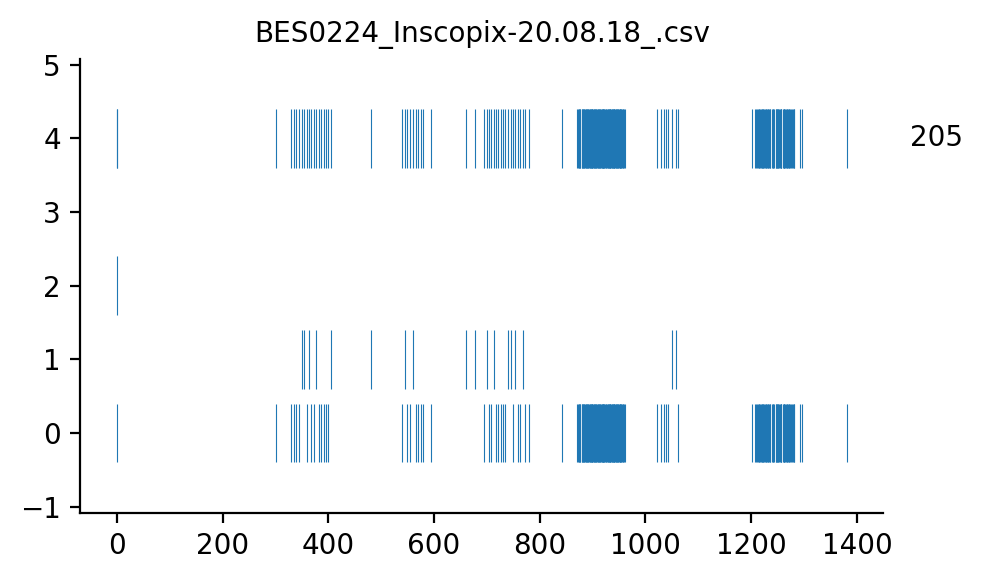

In [5]:
## Load GPIO data with GPIO_event_calculate() function.

## which mouse?
mouse_id = 'BES0224'
# mouse_id = 'BES0225'
# mouse_id = 'BES0233'

# Locate behavioral phenosys file folder
GPIO_folder = '/Users/hunglo/Desktop/GPIO_phenosys_log_file/'+mouse_id+'/processed/'

extension = 'csv'
os.chdir(GPIO_folder)
result = sorted(glob.glob('*.{}'.format(extension)))
# print(result)

# idx for BES0224: 6
# idx for BES0225: -2
# idx for BES0233: 4

idx = 6
P1, P1C, P2, P2A, Pump_all = GPIO_event_calculate(GPIO_folder+result[idx])

file_date = result[idx].split('-')[-1].split('.')[0] + result[idx].split('-')[-1].split('.')[1] + result[idx].split('-')[-1].split('.')[2][:-1]

mpl.rc_file_defaults()
plt.figure(figsize=[5,3])
plt.title(result[idx],fontsize=10)
plt.eventplot(Pump_all,lineoffsets = 4,linelengths = 0.8,linewidths=0.4)
plt.eventplot([P1,P1C,P2,P2A],linelengths = 0.8,linewidths=0.4)
plt.text(s=len(Pump_all),x=1600,y=4,va='center',ha='right')
sns.despine()
plt.tight_layout()

In [6]:
## Load Ca2+ events & synced GPIO file in Inscopix system and align time scales between phenosys and Inscopix recordings

event_path = '/Users/hunglo/Desktop/3rd_supervision/Ca2_trace_csv/CNMFe_pnr20_mincorr08/'+mouse_id+file_date+'_celltraces_ED.csv'
df_event=pd.read_csv(event_path, header=0,skiprows=[1],index_col=0)
df_event.head()

sort = 1

if sort == True:
    ## Load Inscopix_GPIO to align Ca2+ data with phenosys
    file_path = event_path[0:-17]+'GPIO.csv'
    sheet=pd.read_csv(file_path, header=[0], index_col=0)
    if mouse_id != 'BES0224':
        # Select the channel that has initial artifacts during 300 - 315 period.
        channels = [' GPIO-1',' GPIO-2',' GPIO-3',' GPIO-4']
        min_value = []
        for channel in  channels:
            min_value.append(sheet.loc[sheet[' Channel Name']== channel][300:315][' Value'].min())
        min_value = np.array(min_value)
        channel_num = np.argmin(min_value)
        gpiosub=sheet.loc[sheet[' Channel Name']== channels[channel_num]]
    else:
        ## Change this line for IO1 or IO2
        # Select the channel that has initial artifacts during 300 - 315 period.
        channels = [' IO1',' IO2']
        min_value = []
        for channel in  channels:
            min_value.append(sheet.loc[sheet[' Channel Name']== channel][300:315][' Value'].min())
        min_value = np.array(min_value)
        channel_num = np.argmin(min_value)
        gpiosub=sheet.loc[sheet[' Channel Name']== channels[channel_num]]
        # gpiosub=sheet.loc[sheet[' Channel Name']== ' IO1']
    print('Channel selected: '+channels[channel_num])
    Inscopix_GPIO_init = gpiosub[' Value'][300:315].idxmin()

    # Inscopix_GPIO_init
    # Calculate time difference
    if len(P1) == 1:
        if np.min(abs(find_nearest(P2,300)-300)) > np.min(abs(find_nearest(P2A,300)-300)):
            time_diff = Inscopix_GPIO_init - find_nearest(P2A,300)
        else:
            time_diff = Inscopix_GPIO_init - find_nearest(P2,300)
    else:
        if abs(find_nearest(P1,300)-300) > abs(find_nearest(P1C,300)-300):
            time_diff = Inscopix_GPIO_init - find_nearest(P1C,300)
        else:
            time_diff = Inscopix_GPIO_init - find_nearest(P1,300)
else:
    time_diff = 0
print(time_diff)

## Load 
# # Pivot the dataframe for all time stamps for easy handling
# df_spike_binary = df_event.pivot(columns=' Cell Name',values=' Value').fillna(0)
# df_spike_binary[df_spike_binary>0] = 1 # Make deconvoluted values to 1
# df_spike_binary.index = df_spike_binary.index-time_diff
# df_spike_binary.head()

Channel selected:  IO1
12.160996000000011


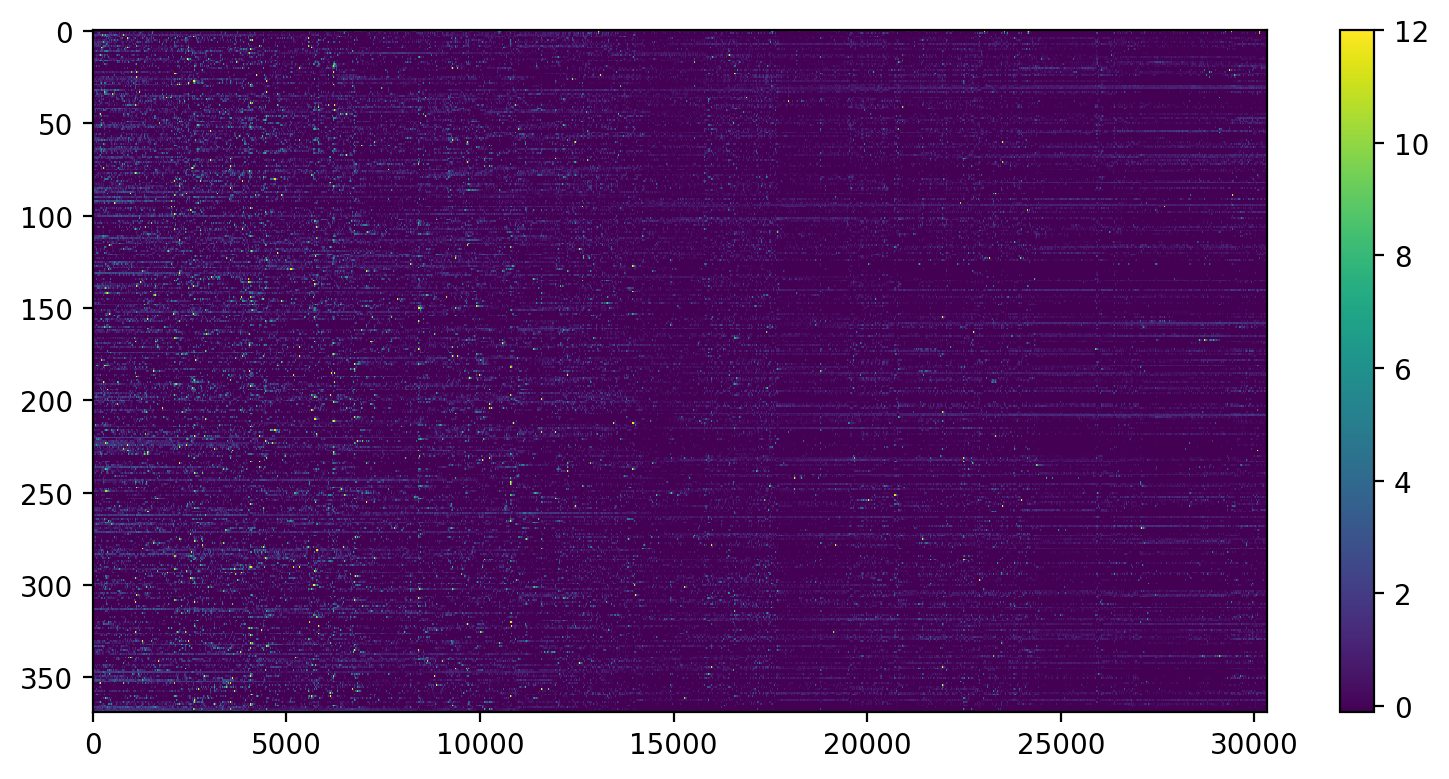

In [7]:
## Load Cs2+ ∆F/F data (only accepted cells) & visualize it
from scipy import stats
dff_path = event_path.split('.')[0][:-3]+'.csv'
df_all = pd.read_csv(dff_path,header=[0,1],index_col=0)
df_accepted = df_all.xs(' accepted',level='Time(s)/Cell Status',axis=1)
df_accepted.index = df_accepted.index-time_diff

save_file_name = dff_path.split('.')[0].split('/')[-1].split('_')[0]

df_z = df_accepted.apply(stats.zscore,axis=0)
plt.figure(figsize=[8,4])
plt.imshow(df_z.T,aspect='auto',vmin=-0.1, vmax=12, cmap='viridis')
plt.colorbar()
plt.tight_layout()

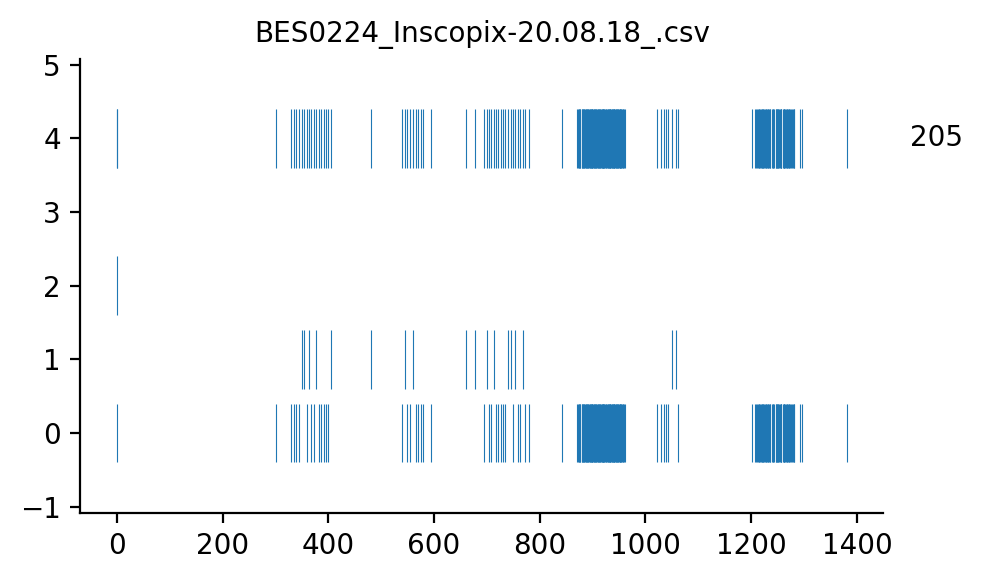

In [8]:
# Show behavior data again to match the slow eating and binge eating bouts (different recordings/animals are different)
plt.figure(figsize=[5,3])
plt.title(result[idx],fontsize=10)
plt.eventplot(Pump_all,lineoffsets = 4,linelengths = 0.8,linewidths=0.4)
plt.eventplot([P1,P1C,P2,P2A],linelengths = 0.8,linewidths=0.4)
plt.text(s=len(Pump_all),x=1600,y=4,va='center',ha='right')
sns.despine()
plt.tight_layout()

In [9]:
# Reduce 4 channels to 2 channels and convter them to pd.DataFrae for easier control on timing.
# Convert P1/P1C or P2/P2A to dataframe
if P2.size==0 or P2A.size==0:
    # print('work')
    GPIO1_df = pd.DataFrame([P1,np.ones(len(P1))]).T
    GPIO1_df.columns = ['timestamps', 'value']
    GPIO1_df = GPIO1_df.set_index('timestamps')
    GPIO1C_df = pd.DataFrame([P1C,np.ones(len(P1C))]).T
    GPIO1C_df.columns = ['timestamps', 'value']
    GPIO1C_df = GPIO1C_df.set_index('timestamps')
else:
    GPIO1_df = pd.DataFrame([P2,np.ones(len(P2))]).T
    GPIO1_df.columns = ['timestamps', 'value']
    GPIO1_df = GPIO1_df.set_index('timestamps')
    GPIO1C_df = pd.DataFrame([P2A,np.ones(len(P2A))]).T
    GPIO1C_df.columns = ['timestamps', 'value']
    GPIO1C_df = GPIO1C_df.set_index('timestamps')

## Manual adjustment for each recording/animals

# For BES0224
# Get timestamps for slow eating/milk deliveries
s_lick_p1_1 = GPIO1_df[300:450].index.values[1:]
s_lick_p1_2 = GPIO1_df[450:600].index.values[0:] 
s_lick_p1_3 = GPIO1_df[650:800].index.values[0:]
s_lick_p1_4 = GPIO1_df[1000:1200].index.values[1:] # remove init
s_lick_p1_4 = np.array([]) 
s_lick_p1_5 = np.array([])

import itertools

s_lick_p1_combined = [s_lick_p1_1, s_lick_p1_2, s_lick_p1_3, s_lick_p1_4, s_lick_p1_5]
s_lick_p1_flatten = list(itertools.chain.from_iterable(s_lick_p1_combined))
s_lick_p1_flatten 

# Get timestamps for binge eating (always milk deliveries)
binging_1 = GPIO1_df[800:1000].index.values[1:] # remove init
binging_2 = GPIO1_df[1200:1350].index.values[1:] # remove init

b_lick_p1_combined = [binging_1, binging_2]
b_lick_p1_flatten = list(itertools.chain.from_iterable(b_lick_p1_combined))

## For BES0225
# # Get timestamps for slow eating/milk deliveries
# s_lick_p1_1 = GPIO1_df[300:450].index.values[1:]
# s_lick_p1_2 = GPIO1_df[450:600].index.values[0:] 
# s_lick_p1_3 = np.array([]) 
# s_lick_p1_4 = np.array([]) 
# s_lick_p1_5 = np.array([])

# import itertools

# s_lick_p1_combined = [s_lick_p1_1, s_lick_p1_2, s_lick_p1_3, s_lick_p1_4, s_lick_p1_5]
# s_lick_p1_flatten = list(itertools.chain.from_iterable(s_lick_p1_combined))
# s_lick_p1_flatten 

# # Get timestamps for binge eating (always milk deliveries)
# # binging_1 = GPIO1_df[800:1000].index.values[1:] # remove init
# binging_1 = np.array([])
# binging_2 = GPIO1_df[1200:1350].index.values[1:] # remove init

# b_lick_p1_combined = [binging_1, binging_2]
# b_lick_p1_flatten = list(itertools.chain.from_iterable(b_lick_p1_combined))
# # b_lick_p1_flatten

# ## For BES0233
# # Get timestamps for slow eating/milk deliveries
# s_lick_p1_1 = GPIO1_df[300:450].index.values[1:]
# s_lick_p1_2 = GPIO1_df[450:600].index.values[1:] 
# s_lick_p1_3 = np.array([]) 
# s_lick_p1_4 = GPIO1_df[1000:1200].index.values[1:] 
# s_lick_p1_5 = GPIO1_df[1350:].index.values[1:] 

# import itertools

# s_lick_p1_combined = [s_lick_p1_1, s_lick_p1_2, s_lick_p1_3, s_lick_p1_4, s_lick_p1_5]
# s_lick_p1_flatten = list(itertools.chain.from_iterable(s_lick_p1_combined))
# s_lick_p1_flatten 

# # Get timestamps for binge eating (always milk deliveries)
# # binging_1 = GPIO1_df[800:1000].index.values[1:] # remove init
# binging_1 = np.array([])
# binging_2 = GPIO1_df[1200:1350].index.values[1:] # remove init

# b_lick_p1_combined = [binging_1, binging_2]
# b_lick_p1_flatten = list(itertools.chain.from_iterable(b_lick_p1_combined))
# # b_lick_p1_flatten


print(len(s_lick_p1_flatten))
print(len(b_lick_p1_flatten))

33
142


Trial: 1 
 1.0 
 0.9848484848484849
Trial: 2 
 0.9848484848484849 
 0.9848484848484849
Trial: 3 
 0.9848484848484849 
 0.9848484848484849
Trial: 4 
 0.9848484848484849 
 0.9848484848484849
Trial: 5 
 1.0 
 0.9848484848484849
Trial: 6 
 1.0 
 1.0
Trial: 7 
 1.0 
 0.9848484848484849
Trial: 8 
 0.9848484848484849 
 0.9848484848484849
Trial: 9 
 0.9848484848484849 
 0.9848484848484849
Trial: 10 
 1.0 
 1.0
Trial: 11 
 0.9848484848484849 
 0.9848484848484849
Trial: 12 
 0.9848484848484849 
 0.9848484848484849
Trial: 13 
 1.0 
 0.9848484848484849
Trial: 14 
 1.0 
 0.9848484848484849
Trial: 15 
 0.9696969696969697 
 0.9848484848484849
Trial: 16 
 1.0 
 1.0
Trial: 17 
 1.0 
 0.9848484848484849
Trial: 18 
 0.9696969696969697 
 1.0
Trial: 19 
 0.9545454545454546 
 0.9848484848484849
Trial: 20 
 0.9848484848484849 
 0.9848484848484849
Trial: 21 
 1.0 
 1.0
Trial: 22 
 0.9545454545454546 
 0.9848484848484849
Trial: 23 
 0.9848484848484849 
 1.0
Trial: 24 
 0.9696969696969697 
 0.9848484848484849
T

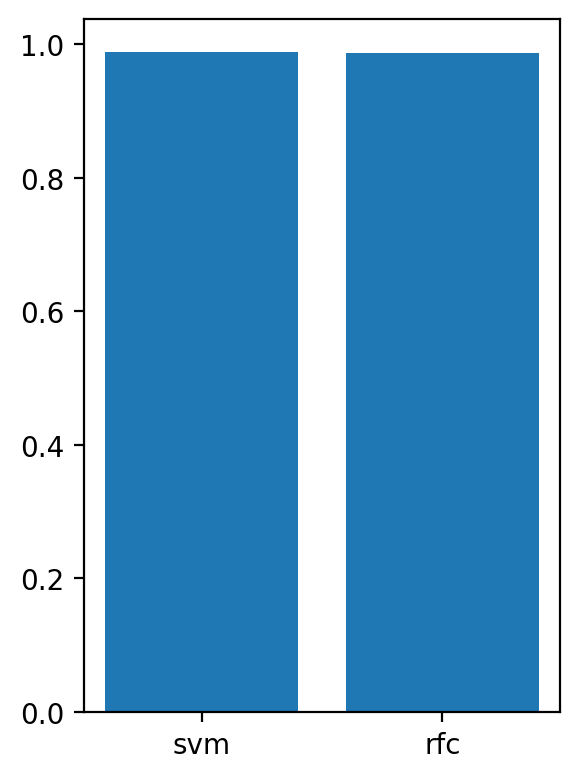

In [10]:
## SVM/RFC with balanced trial numbers
## Binge trials are more than slow eatings, so randomly pick the same numbers of binge trials as slow eating trisls

# Load data
data = df_z.copy()

# initiate score list
score_svm_avg_100 = []
score_rfc_avg_100 = []

for j in range(100):
    milk_trials = []
    binge_trials = []
    # Balance classes by their lengths
    # Rondomly pick up same amount of binge deliveries as milk deliveries
    milk_trials = s_lick_p1_flatten
    binge_trials = sorted(np.random.choice(b_lick_p1_flatten,len(s_lick_p1_flatten),replace=False))
    # binge_trials = b_lick_p1_flatten

    ## Design matrix of max Ca2+ amplitude within 2 sec after the onset
    PSTH_trace = pd.DataFrame()
    for idx,time in enumerate(milk_trials):
        PSTH_trace[time]=(data[time:time+2].max().reset_index(drop=True))
    PSTH_trace = PSTH_trace.T
    PSTH_trace['Binge']=np.zeros(PSTH_trace.shape[0],dtype=bool) # Labeled as Binge==False

    ## For the binging events, control for the duration of deliveries. 
    ## This is originally wrote for all binge trials, a modified version can be found in below for number matched trials
    # # If ITI >2, then take max value from time:time+2.
    # # If ITI <2, then take max value from time_current_delivery to time_next_delivery.
    # diff_duration = [time_1-time_2 for time_1,time_2 in zip(binge_trials[1:],binge_trials[:-1])]
    # diff_bigger_2 = [time_1-time_2>2 for time_1,time_2 in zip(binge_trials[1:],binge_trials[:-1])]
    # diff_bigger_2.append(True) # padding for the last delivery to make the list same length, and assign the last IEI is bigger than 2 sec.

    # initiate lists
    diff_duration = []
    diff_bigger_2 = []

    for t in binge_trials[:-1]:
        idx = np.where(b_lick_p1_flatten == t)
        diff_duration.append(b_lick_p1_flatten[int(idx[0])+1]-b_lick_p1_flatten[int(idx[0])])
        diff_bigger_2.append(b_lick_p1_flatten[int(idx[0])+1]-b_lick_p1_flatten[int(idx[0])]>2)
    diff_bigger_2.append(True) # padding for the last delivery to make the list same length, and assign the last IEI is bigger than 2 sec.

    ## Compute design matrix of max Ca2+ amplitude within 2 sec or before next delivery
    PSTH_trace_b = pd.DataFrame()
    for idx,time in enumerate(binge_trials):
        if diff_bigger_2[idx] == True:
            PSTH_trace_b[time]=(data[time:time+2].max().reset_index(drop=True))
            # print(time,'ITI bigger than 2 sec')
        else:
            PSTH_trace_b[time]=(data[time:time+diff_duration[idx]].max().reset_index(drop=True))
            # print(time,'ITI smaller than 2 sec')
    PSTH_trace_b = PSTH_trace_b.T
    PSTH_trace_b['Binge']=np.ones(PSTH_trace_b.shape[0],dtype=bool) # Labeled as Binge==True

    PSTH_all = pd.concat([PSTH_trace,PSTH_trace_b])

    ## Shuffle data frame rows (not necessary but nice to make the CV more diverse)
    PSTH_all = PSTH_all.sample(frac=1).reset_index(drop=True)
    # PSTH_all.head()

    ## SVM & RFC

    # Set x & y
    X = PSTH_all.iloc[:,:-1]
    y = PSTH_all.iloc[:,-1]

    # CV
    cv = StratifiedKFold(n_splits=6)
    svc = svm.SVC(kernel='linear', probability=True)
    rfc = RandomForestClassifier()

    score_svm = []
    auc_svm = []
    score_rfc = []
    auc_rfc = []

    # fig, ax = plt.subplots(figsize=[6,5])
    for i, (train, test) in enumerate(cv.split(X, y)):
        svc.fit(X.iloc[train], y.iloc[train])
        rfc.fit(X.iloc[train], y.iloc[train])

        score_svm.append(svc.score(X.iloc[test], y.iloc[test]))
        score_rfc.append(rfc.score(X.iloc[test], y.iloc[test]))

    score_svm_avg_100.append(np.mean(score_svm))
    score_rfc_avg_100.append(np.mean(score_rfc))    
    print('Trial:',j+1, '\n',np.mean(score_svm),'\n', np.mean(score_rfc))
plt.figure(figsize=[3,4])
plt.bar(['svm','rfc'],[np.mean(score_svm_avg_100),np.mean(score_rfc_avg_100)])
plt.tight_layout()
print(np.mean(score_svm_avg_100), np.mean(score_rfc_avg_100))

Trial: 1 
 0.45454545454545453 
 0.5151515151515151
Trial: 2 
 0.5151515151515151 
 0.409090909090909
Trial: 3 
 0.4393939393939394 
 0.4696969696969697
Trial: 4 
 0.5151515151515151 
 0.5606060606060607
Trial: 5 
 0.4393939393939394 
 0.45454545454545453
Trial: 6 
 0.5909090909090909 
 0.6060606060606061
Trial: 7 
 0.4696969696969697 
 0.48484848484848486
Trial: 8 
 0.5151515151515151 
 0.5454545454545454
Trial: 9 
 0.5454545454545454 
 0.5303030303030303
Trial: 10 
 0.6363636363636364 
 0.6212121212121212
Trial: 11 
 0.5606060606060606 
 0.37878787878787873
Trial: 12 
 0.5606060606060606 
 0.5606060606060607
Trial: 13 
 0.5303030303030303 
 0.5151515151515151
Trial: 14 
 0.6666666666666666 
 0.5
Trial: 15 
 0.48484848484848486 
 0.48484848484848486
Trial: 16 
 0.5151515151515151 
 0.4696969696969697
Trial: 17 
 0.5151515151515151 
 0.5454545454545454
Trial: 18 
 0.5909090909090909 
 0.42424242424242425
Trial: 19 
 0.5151515151515151 
 0.4545454545454546
Trial: 20 
 0.7424242424242425

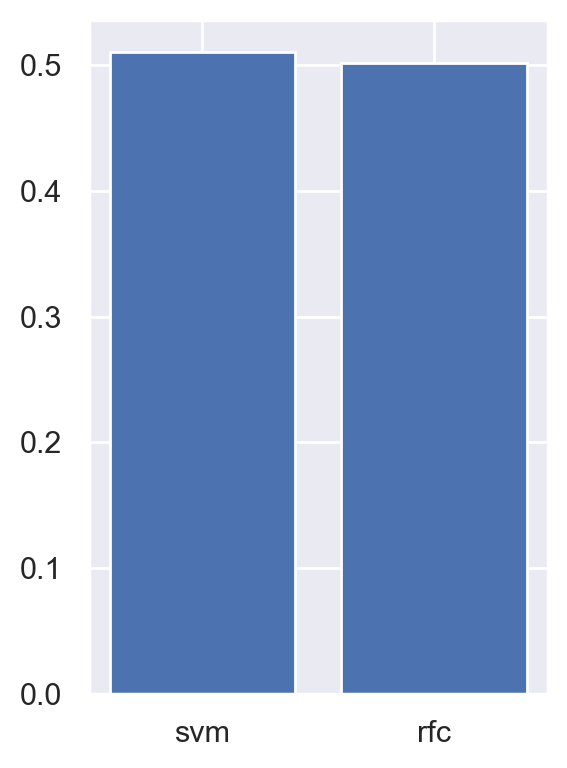

In [18]:
## For shulffled dataset
## New svm/rfc with balanced trial numbers

data = df_z.copy()

score_svm_avg_100_s = []
score_rfc_avg_100_s = []

for j in range(100):
    milk_trials = []
    binge_trials = []
    # Balance classes by their lengths
    # Rondomly pick up same amount of binge deliveries as milk deliveries
    milk_trials = s_lick_p1_flatten
    binge_trials = sorted(np.random.choice(b_lick_p1_flatten,len(s_lick_p1_flatten),replace=False))

    ## Design matrix of max Ca2+ amplitude within 2 sec after the onset

    PSTH_trace = pd.DataFrame()
    for idx,time in enumerate(milk_trials):
        PSTH_trace[time]=(data[time:time+2].max().reset_index(drop=True))
    PSTH_trace = PSTH_trace.T
    PSTH_trace['Binge']=np.zeros(PSTH_trace.shape[0],dtype=bool)

    # ## For the binging events, control for the duration of deliveries. 
    # # If IEI >2, then take max value from time:time+2.
    # # If IEI <2, then take max value from time_current_delivery to time_next_delivery.

    # diff_duration = [time_1-time_2 for time_1,time_2 in zip(binge_trials[1:],binge_trials[:-1])]
    # diff_bigger_2 = [time_1-time_2>2 for time_1,time_2 in zip(binge_trials[1:],binge_trials[:-1])]
    # diff_bigger_2.append(True) # padding for the last delivery to make the list same length, and assign the last IEI is bigger than 2 sec.

    # initiate lists
    diff_duration = []
    diff_bigger_2 = []

    for t in binge_trials[:-1]:
        idx = np.where(b_lick_p1_flatten == t)
        diff_duration.append(b_lick_p1_flatten[int(idx[0])+1]-b_lick_p1_flatten[int(idx[0])])
        diff_bigger_2.append(b_lick_p1_flatten[int(idx[0])+1]-b_lick_p1_flatten[int(idx[0])]>2)
    diff_bigger_2.append(True) # padding for the last delivery to make the list same length, and assign the last IEI is bigger than 2 sec.

    ## Compute design matrix of max Ca2+ amplitude within 2 sec or before next delivery
    PSTH_trace_b = pd.DataFrame()
    for idx,time in enumerate(binge_trials):
        if diff_bigger_2[idx] == True:
            PSTH_trace_b[time]=(data[time:time+2].max().reset_index(drop=True))
            # print(time,'ITI bigger than 2 sec')
        else:
            PSTH_trace_b[time]=(data[time:time+diff_duration[idx]].max().reset_index(drop=True))
            # print(time,'ITI smaller than 2 sec')
    PSTH_trace_b = PSTH_trace_b.T
    PSTH_trace_b['Binge']=np.ones(PSTH_trace_b.shape[0],dtype=bool) # Labeled as Binge==True

    PSTH_all = pd.concat([PSTH_trace,PSTH_trace_b])
    # PSTH_all.head()
    PSTH_all_shuffle = PSTH_all.copy().reset_index(drop=True)

    ## Shuffle data labels column
    PSTH_all_shuffle['Binge'] = PSTH_all_shuffle['Binge'].sample(frac=1).reset_index(drop=True)
    
    ## Shuffle data frame (all rows), not necessary.
    PSTH_all_shuffle = PSTH_all_shuffle.sample(frac=1).reset_index(drop=True)

    ## Perform svm & rfc

    ## Set x & y
    X = PSTH_all_shuffle.iloc[:,:-1]
    y = PSTH_all_shuffle.iloc[:,-1]

    # CV
    cv = StratifiedKFold(n_splits=6)
    svc = svm.SVC(kernel='linear', probability=True)
    rfc = RandomForestClassifier()

    score_svm = []
    auc_svm = []
    score_rfc = []
    auc_rfc = []

    # fig, ax = plt.subplots(figsize=[6,5])
    for i, (train, test) in enumerate(cv.split(X, y)):
        svc.fit(X.iloc[train], y.iloc[train])
        rfc.fit(X.iloc[train], y.iloc[train])

        score_svm.append(svc.score(X.iloc[test], y.iloc[test]))
        score_rfc.append(rfc.score(X.iloc[test], y.iloc[test]))

    score_svm_avg_100_s.append(np.mean(score_svm))
    score_rfc_avg_100_s.append(np.mean(score_rfc))    
    print('Trial:',j+1, '\n',np.mean(score_svm),'\n', np.mean(score_rfc))
plt.figure(figsize=[3,4])
plt.bar(['svm','rfc'],[np.mean(score_svm_avg_100_s),np.mean(score_rfc_avg_100_s)])
plt.tight_layout()
print(np.mean(score_svm_avg_100_s), np.mean(score_rfc_avg_100_s))

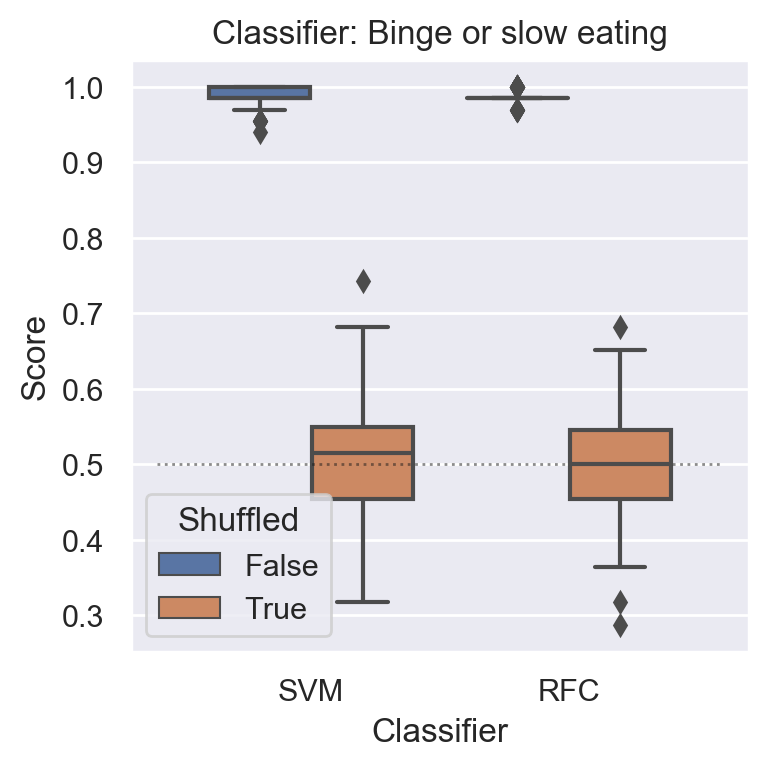

In [23]:
## Plotting setting
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 8})

## More clear plot with sns
## Only with svm + rfc (combined with shuffled dat)
score = pd.DataFrame([score_svm_avg_100,score_rfc_avg_100])
score = score.T
score.columns=['SVM','RFC']
score = score.melt(var_name="Classifier")
score.columns=['Classifier','Score']
score['Shuffled'] = np.zeros(score.shape[0],dtype=bool)

score_s = pd.DataFrame([score_svm_avg_100_s,score_rfc_avg_100_s])
score_s = score_s.T
score_s.columns=['SVM','RFC']
score_s = score_s.melt(var_name="Classifier")
score_s.columns=['Classifier','Score']
score_s['Shuffled'] = np.ones(score_s.shape[0],dtype=bool)

score_all = pd.concat([score,score_s])
data = score_all
# data = score

sns.set()

from numpy import median
from scipy.stats import sem

sem_svm = sem(score_svm_avg_100)
sem_rfc = sem(score_rfc_avg_100)
error_sem = [sem_svm,sem_rfc]

std_svm = np.std(score_svm_avg_100)
std_rfc = np.std(score_rfc_avg_100)
error_std = [std_svm,std_rfc]

fig,ax = plt.subplots(figsize=[4,4])
sns.boxplot(x="Classifier", y="Score",data=data,hue='Shuffled')
plt.hlines(y=0.5,xmin=-0.6,xmax=1.6,ls=':',lw=1,label='Chance level',alpha=0.5)

plt.title('Classifier: Binge or slow eating')
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/svm/svm_rfc_boxplot_binge_'+save_file_name+'.pdf',dpi=600)
plt.show()

score_all.to_csv('/Users/hunglo/Desktop/3rd_supervision/svm/svm_rfc_score_binge_'+save_file_name+'.csv')

In [ ]:
## Load all 3 data set together

df_1 = pd.read_csv('/Users/hunglo/Desktop/3rd_supervision/svm/svm_rfc_score_binge_BES0224200818.csv',usecols=['Score','Classifier','Shuffled'])
df_2 = pd.read_csv('/Users/hunglo/Desktop/3rd_supervision/svm/svm_rfc_score_binge_BES0225201007.csv',usecols=['Score','Classifier','Shuffled'])
df_3 = pd.read_csv('/Users/hunglo/Desktop/3rd_supervision/svm/svm_rfc_score_binge_BES0233200912.csv',usecols=['Score','Classifier','Shuffled'])

df_all = pd.concat([df_1,df_2,df_3]).reset_index(drop=True)
df_all

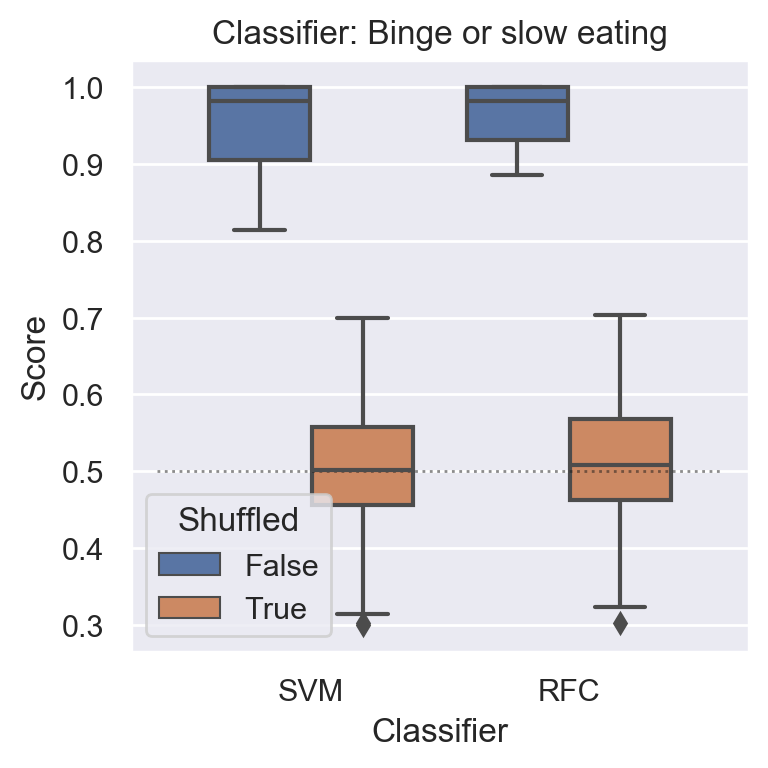

In [46]:
## Plotting setting
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 8})

data = df_all

sns.set()

from numpy import median
from scipy.stats import sem

sem_svm = sem(score_svm_avg_100)
sem_rfc = sem(score_rfc_avg_100)
error_sem = [sem_svm,sem_rfc]

std_svm = np.std(score_svm_avg_100)
std_rfc = np.std(score_rfc_avg_100)
error_std = [std_svm,std_rfc]

fig,ax = plt.subplots(figsize=[4,4])
sns.boxplot(x="Classifier", y="Score",data=data,hue='Shuffled')
plt.hlines(y=0.5,xmin=-0.6,xmax=1.6,ls=':',lw=1,label='Chance level',alpha=0.5)
# plt.annotate(xy=[0.3,df_1_svm_mean],s='mouse_1',ha='center',marker='.')
# plt.plot(-0.3,df_1_svm_mean,marker='D',ls='',label='mouse_1',color='k')

plt.title('Classifier: Binge or slow eating')
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/svm/svm_rfc_binge_boxplot_all_3mice.pdf',dpi=600)
plt.show()